## Multilayer Perceptron

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

In [2]:
# Hyperparameters 
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 50
batch_size = 100
learning_rate = 0.001

- MNISTはPyTorchの標準機能でデータセットをダウンロードできる
- バッチ単位で読み込めるDataLoaderも簡単に使える

In [3]:
# MNIST Dataset (Images and Labels)
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

# Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

- DataSetのlen()はサンプル数を返す
- DataLoaderのlen()はミニバッチ数を返す

In [4]:
print(len(train_dataset))  # 60000
print(len(test_dataset))   # 10000
print(len(train_loader))   # 600
print(len(test_loader))    # 100

60000
10000
600
100


- DataLoaderから1バッチ分のデータを取り出す方法
- DataLoaderをiterで囲んでnext()すればよい

In [5]:
# 1データだけ取得
image, label = iter(train_loader).next()
print(type(image))   # <class 'torch.FloatTensor'>
print(type(label))   # <class 'torch.LongTensor'>
print(image.size())  # torch.Size([100, 1, 28, 28])
print(label.size())  # torch.Size([100])

<class 'torch.FloatTensor'>
<class 'torch.LongTensor'>
torch.Size([100, 1, 28, 28])
torch.Size([100])


(-0.5, 145.5, 145.5, -0.5)

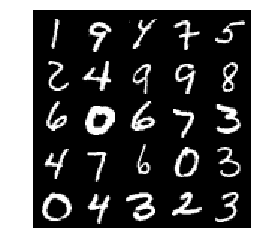

In [6]:
# 可視化
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    npimg = img.numpy()
    # [c, h, w] => [h, w, c]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = iter(train_loader).next()
images, labels = images[:25], labels[:25]
imshow(torchvision.utils.make_grid(images, nrow=5, padding=1))
plt.axis('off')

In [15]:
class MultiLayerPerceptron(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
#         print(x.size())
        out = self.fc1(x)
#         print(out.size())
        out = self.relu(out)
#         print(out.size())
        out = self.fc2(out)
#         print(out.size())
        return out

- Sequentialを使ってまとめて書く方法もある
- forward処理中に出力値を見られる

In [21]:
model = MultiLayerPerceptron(input_size, hidden_size, num_classes)

In [22]:
# テスト
image, label = iter(train_loader).next()
print("befire view:", image.size())
image = image.view(-1, 28 * 28)
print("after view:", image.size())
model(Variable(image))

befire view: torch.Size([100, 1, 28, 28])
after view: torch.Size([100, 784])


Variable containing:
 0.0317 -0.1562 -0.0839  ...   0.0817 -0.0818  0.0060
 0.0405 -0.1823 -0.0545  ...  -0.0444 -0.1001 -0.0525
 0.0298 -0.1331 -0.1297  ...  -0.0319 -0.0913 -0.0279
          ...             ⋱             ...          
-0.0380 -0.1099 -0.0866  ...  -0.0179 -0.1349 -0.0201
-0.0013 -0.1066 -0.1003  ...   0.0212 -0.0724 -0.0462
-0.0178 -0.2066 -0.1956  ...  -0.0597 -0.1184 -0.1106
[torch.FloatTensor of size 100x10]

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [24]:
def train(train_loader):
    model.train()
    running_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)
        
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        running_loss += loss.data[0]

        loss.backward()
        optimizer.step()

    train_loss = running_loss / len(train_loader)
    
    return train_loss


def valid(test_loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = Variable(images.view(-1, 28 * 28), volatile=True)
        labels = Variable(labels, volatile=True)

        outputs = model(images)

        loss = criterion(outputs, labels)
        running_loss += loss.data[0]

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels.data).sum()
        total += labels.size(0)

    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    
    return val_loss, val_acc


loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(num_epochs):
    loss = train(train_loader)
    val_loss, val_acc = valid(test_loader)

    print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f'
          % (epoch, loss, val_loss, val_acc))
    
    # logging
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, loss: 2.2323 val_loss: 2.1597 val_acc: 0.5529
epoch 1, loss: 2.0872 val_loss: 1.9985 val_acc: 0.6811
epoch 2, loss: 1.9131 val_loss: 1.8036 val_acc: 0.7289
epoch 3, loss: 1.7109 val_loss: 1.5890 val_acc: 0.7565
epoch 4, loss: 1.5013 val_loss: 1.3807 val_acc: 0.7772
epoch 5, loss: 1.3083 val_loss: 1.1997 val_acc: 0.7973
epoch 6, loss: 1.1462 val_loss: 1.0531 val_acc: 0.8131
epoch 7, loss: 1.0167 val_loss: 0.9382 val_acc: 0.8248
epoch 8, loss: 0.9152 val_loss: 0.8486 val_acc: 0.8364
epoch 9, loss: 0.8355 val_loss: 0.7779 val_acc: 0.8437
epoch 10, loss: 0.7720 val_loss: 0.7214 val_acc: 0.8490
epoch 11, loss: 0.7207 val_loss: 0.6754 val_acc: 0.8551
epoch 12, loss: 0.6786 val_loss: 0.6374 val_acc: 0.8602
epoch 13, loss: 0.6435 val_loss: 0.6052 val_acc: 0.8637
epoch 14, loss: 0.6137 val_loss: 0.5780 val_acc: 0.8679
epoch 15, loss: 0.5882 val_loss: 0.5546 val_acc: 0.8712
epoch 16, loss: 0.5662 val_loss: 0.5342 val_acc: 0.8739
epoch 17, loss: 0.5469 val_loss: 0.5165 val_acc: 0.8758
ep

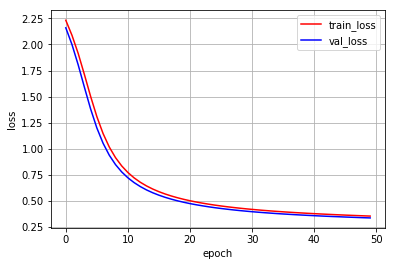

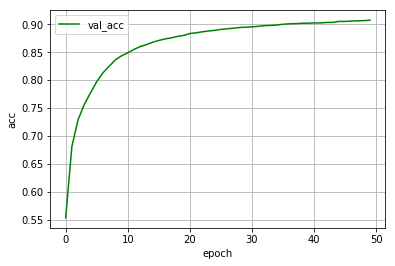

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot learning curve
plt.figure()
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, 'b-', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid()